In [29]:
import os, sys

import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline

import pandas as pd
import numpy as np

# import Image from PIL
from PIL import Image

from skimage.feature import hog
from skimage.color import rgb2gray

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# import train_test_split from sklearn's model selection module
from sklearn.model_selection import train_test_split

# import SVC from sklearn's svm module
from sklearn.svm import SVC

# import accuracy_score from sklearn's metrics module
from sklearn.metrics import roc_curve, auc, accuracy_score

#
HIGHLIGHT_ON = '\x1b[1;33;40m'
HIGHLIGHT_OFF =  '\x1b[m!'

## BeeImage Dataset
https://www.kaggle.com/datasets/jenny18/honey-bee-annotated-images

Based on DataCamp's Naive Bees project: https://app.datacamp.com/learn/projects/412

### Data Preprocessing

In [2]:
data = pd.read_csv('bee_data.csv', index_col=0)

# droping subspecies = -1
data.drop(data[data.subspecies == '-1'].index, inplace=True)

data.head()

,date,time,location,zip code,subspecies,health,pollen_carrying,caste
file,,,,,,,,
017_029.png,8/6/18,13:21,"Saratoga, CA, USA",95070,Italian honey bee,healthy,False,worker
017_015.png,8/6/18,13:21,"Saratoga, CA, USA",95070,Italian honey bee,healthy,False,worker
017_001.png,8/6/18,13:21,"Saratoga, CA, USA",95070,Italian honey bee,healthy,False,worker
017_000.png,8/6/18,13:21,"Saratoga, CA, USA",95070,Italian honey bee,healthy,False,worker
017_014.png,8/6/18,13:21,"Saratoga, CA, USA",95070,Italian honey bee,healthy,False,worker


In [5]:
# removing all other collumns
data = data[['subspecies']]
data.head()

In [7]:
pd.Series(data['subspecies']).value_counts()

Italian honey bee        3008
Russian honey bee         527
Carniolan honey bee       501
1 Mixed local stock 2     472
VSH Italian honey bee     199
Western honey bee          37
Name: subspecies, dtype: int64

In [8]:
# considering only two species
data2 = data.query('subspecies == "Russian honey bee" or subspecies == "Carniolan honey bee"')
data2.head()

,subspecies
file,
011_027.png,Carniolan honey bee
011_018.png,Carniolan honey bee
011_030.png,Carniolan honey bee
011_024.png,Carniolan honey bee
011_025.png,Carniolan honey bee


In [9]:
pd.Series(data2['subspecies']).value_counts()

Russian honey bee      527
Carniolan honey bee    501
Name: subspecies, dtype: int64

In [10]:
col_encoding = {'subspecies': 
                    {'Russian honey bee': 0, 'Carniolan honey bee': 1}
               }

data2 = data2.replace(col_encoding)
data2.head()

,subspecies
file,
011_027.png,1
011_018.png,1
011_030.png,1
011_024.png,1
011_025.png,1


002_022.png
011_019.png


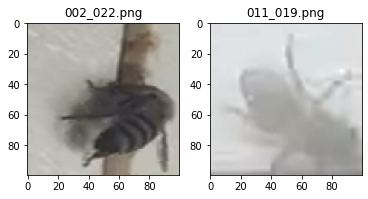

In [11]:
labels = data2['subspecies']

def get_image(img_name, root="bee_imgs/"):
    """
    Converts an image number into the file path where the image is located, 
    opens the image, and returns the image as a numpy array.
    """
    file_path = os.path.join(root, img_name)
    img = Image.open(file_path)
    img = img.resize((100,100))
    
    # two images has 4 layers!
    return np.array(img)[:,:,:3]

# subset the dataframe to just Apis (genus is 0.0) get the value of the sixth item in the index
img_name = data2[data2.subspecies == 0].index[5]
print(img_name)

plt.subplot(1,2,1)
plt.imshow(get_image(img_name))
plt.title(img_name)

# subset the dataframe to just Bombus (genus is 1.0) get the value of the sixth item in the index
img_name = data2[data2.subspecies == 1].index[5]
print(img_name)

# show the corresponding image of a Bombus
plt.subplot(1,2,2)
plt.imshow(get_image(img_name))
plt.title(img_name)
plt.show()

--> Color image shape: (100, 100, 3)!
--> Grayscale image shape: (100, 100)!


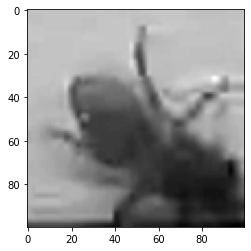

In [31]:
# load a bombus image using our get_image function and bombus_row from the previous cell
img = get_image(img_name)

# print the shape of the bombus image
print(f'--> Color image shape: {HIGHLIGHT_ON}{img.shape}{HIGHLIGHT_OFF}')

# convert the bombus image to grayscale
gray_img = rgb2gray(img)

# show the grayscale image
plt.imshow(gray_img, cmap=mpl.cm.gray)

# grayscale bombus image only has one channel
print(f'--> Grayscale image shape: {HIGHLIGHT_ON}{gray_img.shape}{HIGHLIGHT_OFF}')

## Feature Extraction

### Histogram of Oriented Gradients (HOG)

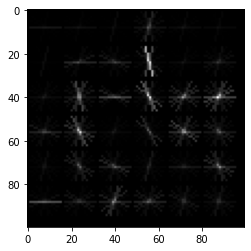

In [13]:
# run HOG using our grayscale bombus image
hog_features, hog_image = hog(img,
                              visualize=True,
                              block_norm='L2-Hys',
                              pixels_per_cell=(16, 16))

# show our hog_image with a gray colormap
plt.imshow(hog_image, cmap=mpl.cm.gray);

### Two features: HOG + Pixel intensities

In [14]:
def create_features(img):
    # flatten three channel color image
    color_features = img.flatten()
    # convert image to grayscale
    gray_image = rgb2gray(img)
    # get HOG features from grayscale image
    hog_features = hog(gray_image, block_norm='L2-Hys', pixels_per_cell=(16, 16))
    # combine color and hog features into a single array
    flat_features = np.hstack((color_features, hog_features))
    return flat_features

bombus_features = create_features(img)

# print shape of bombus_features
print(bombus_features.shape, type(bombus_features), bombus_features)

(31296,) <class 'numpy.ndarray'> [2.25000000e+02 2.26000000e+02 2.29000000e+02 ... 5.19654416e-02
 4.27715697e-02 6.05196450e-02]


In [32]:
def create_feature_matrix(label_dataframe):
    features_list = []
    
    for img_id in label_dataframe.index:
        # load image
        imgi = get_image(img_id)
        # get features for image
        image_features = create_features(imgi)
        features_list.append(image_features)
    
    # convert list of arrays into a matrix
    feature_matrix = np.array(features_list)
    return feature_matrix

# run create_feature_matrix on our dataframe of images
feature_matrix = create_feature_matrix(data2)
print(f'--> Size of the features matrix: {HIGHLIGHT_ON}{feature_matrix.shape}{HIGHLIGHT_OFF}')

--> Size of the features matrix: (1028, 31296)!


In [16]:
img = get_image('032_499.png')
print(img.shape)

(100, 100, 3)


### Splitting data: 70% training, 30% testing

In [17]:
# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(feature_matrix,
                                                    data2.subspecies,
                                                    test_size=.3,
                                                    stratify=data2.subspecies,
                                                    random_state=1234123)

# look at the distribution of labels in the train set
print(pd.Series(y_train).value_counts())
print(pd.Series(y_test).value_counts())

0    369
1    350
Name: subspecies, dtype: int64
0    158
1    151
Name: subspecies, dtype: int64


### Normalization

In [18]:
# get shape of our training features
print('Training features matrix shape is: ', X_train.shape)

# define standard scaler
ss = StandardScaler()

# fit the scaler and transform the training features
train_stand = ss.fit_transform(X_train)

# transform the test features
test_stand = ss.transform(X_test)

# look at the new shape of the standardized feature matrices
print('Standardized training features matrix shape is: ', train_stand.shape)
print('Standardized test features matrix shape is: ', test_stand.shape)

Training features matrix shape is:  (719, 31296)
Standardized training features matrix shape is:  (719, 31296)
Standardized test features matrix shape is:  (309, 31296)


## Principal Component Analysis

In [19]:
# Instantiate a PCA object with 350 components
pca = PCA(n_components=350)

# use fit_transform on our standardized training features
X_train = pca.fit_transform(train_stand)

# use transform on our standardized test features
X_test = pca.transform(test_stand)

# look at new shape
print('Training features matrix is: ', X_train.shape)
print('Test features matrix is: ', X_test.shape)

Training features matrix is:  (719, 350)
Test features matrix is:  (309, 350)


## Classifier: Support Vector Machine (SVM)

In [33]:
# define support vector classifier
svm = SVC(kernel='linear', probability=True, random_state=42)

# fit model
svm.fit(X_train, y_train)

# generate predictions
y_pred = svm.predict(X_test)

# calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'--> Model accuracy {HIGHLIGHT_ON}{accuracy}{HIGHLIGHT_OFF}')

--> Model accuracy 0.9902912621359223!


### Prediction on Test set

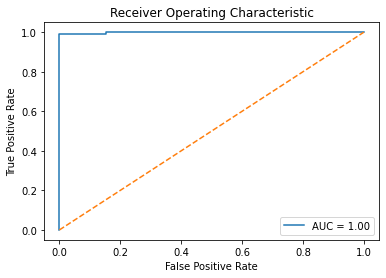

In [21]:
# predict probabilities for X_test using predict_proba
probabilities = svm.predict_proba(X_test)

# select the probabilities for label 1.0
y_proba = probabilities[:,1]

# calculate false positive rate and true positive rate at different thresholds
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_proba, pos_label=1)

# calculate AUC
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Receiver Operating Characteristic')
# plot the false positive rate on the x axis and the true positive rate on the y axis
roc_plot = plt.plot(false_positive_rate,
                    true_positive_rate,
                    label='AUC = {:0.2f}'.format(roc_auc))

plt.legend(loc=0)
plt.plot([0,1], [0,1], ls='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate');